# Code to compare train and test stage of DL model


In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
import re
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../')
from lib.io_utils import *

In [2]:
project_dir = '../'
ml_dir = '{}ml/'.format(project_dir)
results_dir = '{}results/Exp_kaggle/'.format(project_dir)

In [3]:
# experiment_names = ['Exp_pytorch_cifar','Exp_kaggle_mateuszbuda','Exp_kaggle_mateuszbuda_pruned']
exp_idx = range(1,9)
experiment_names = ['Exp_kaggle_mateuszbuda_{}'.format(i) for i in exp_idx] #['Exp_kaggle_mateuszbuda','Exp_kaggle_mateuszbuda_pruned']

devices = ['cuda'] 

jcols = ['experiment_name','device','tag','duration','package_total','dram_total','nvidia_total','process_total']
exp_config_df_concat = pd.DataFrame()
epoch_df_concat = pd.DataFrame()
joules_df_concat = pd.DataFrame()
for exp_name in experiment_names:
    for device in devices:
        exp_config_csv = '{}{}/{}/experiment_config.csv'.format(results_dir,exp_name,device)
        epoch_csv = '{}{}/{}/epoch.csv'.format(results_dir,exp_name,device)
        joules_csv = '{}{}/{}/joules.csv'.format(results_dir,exp_name,device)

        exp_config_df = pd.read_csv(exp_config_csv)
        exp_config_df_concat = exp_config_df_concat.append(exp_config_df)

        epoch_df = pd.read_csv(epoch_csv)
        epoch_df['experiment_name'] = exp_name
        epoch_df['device'] = device
        epoch_df_concat = epoch_df_concat.append(epoch_df)
        
        
        joules_df = read_joules(joules_csv,device)
        joules_df['experiment_name'] = exp_name        
        joules_df_concat = joules_df_concat.append(joules_df[jcols])


exp_config_df_concat

,Unnamed: 0,experiment_name,proc,arch,count,python_version,device,model,MAC,params,n_epochs,batch_size,optimizer,test_perf,train_compute_time,test_compute_time,experiment_compute_time
0,0,Exp_kaggle_mateuszbuda_1,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,X86_64,32,3.7.4.final.0 (64 bit),cuda,unet,12.13 GMac,7.76 M,20,4,adam,60.458712,72.467244,0.023897,160.268875
0,0,Exp_kaggle_mateuszbuda_2,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,X86_64,32,3.7.4.final.0 (64 bit),cuda,unet,12.13 GMac,7.76 M,20,16,adam,47.463502,21.662458,0.021195,173.990355
0,0,Exp_kaggle_mateuszbuda_3,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,X86_64,32,3.7.4.final.0 (64 bit),cuda,unet_medium,3.06 GMac,1.94 M,20,4,adam,50.567410,61.571497,0.019465,191.985579
0,0,Exp_kaggle_mateuszbuda_4,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,X86_64,32,3.7.4.final.0 (64 bit),cuda,unet_medium,3.06 GMac,1.94 M,20,16,adam,52.446383,16.684447,0.017025,70.608759
0,0,Exp_kaggle_mateuszbuda_5,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,X86_64,32,3.7.4.final.0 (64 bit),cuda,unet_small,0.78 GMac,486.55 k,20,4,adam,31.060340,58.338257,0.018801,110.922030
0,0,Exp_kaggle_mateuszbuda_6,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,X86_64,32,3.7.4.final.0 (64 bit),cuda,unet_small,0.78 GMac,486.55 k,20,16,adam,43.637337,14.080043,0.013288,89.056882
0,0,Exp_kaggle_mateuszbuda_7,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,X86_64,32,3.7.4.final.0 (64 bit),cuda,unet_tiny,0.2 GMac,122.09 k,20,4,adam,41.234651,61.013833,0.019165,189.908057
0,0,Exp_kaggle_mateuszbuda_8,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,X86_64,32,3.7.4.final.0 (64 bit),cuda,unet_tiny,0.2 GMac,122.09 k,20,16,adam,40.547938,13.769384,0.013078,153.216051


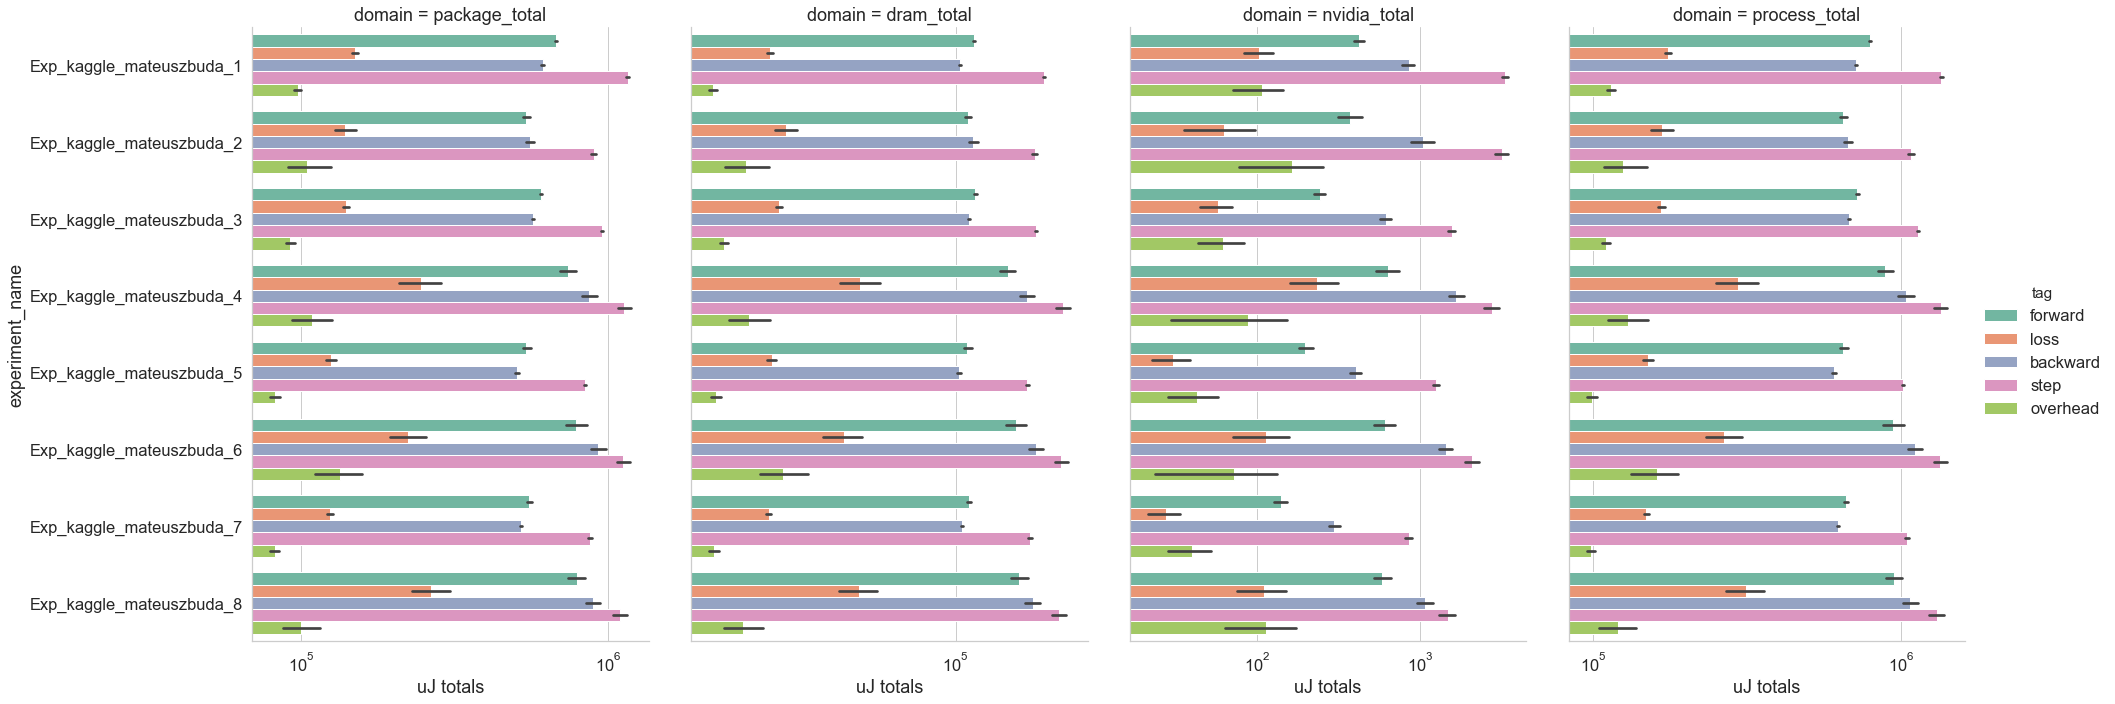

In [18]:
plot_df = joules_df_concat.copy()
plot_df = plot_df[plot_df['device']=='cuda']
plot_df = pd.melt(plot_df, id_vars=['experiment_name','device','tag','duration'], value_vars=['package_total','dram_total','nvidia_total','process_total'],
 var_name='domain', value_name='uJ totals')

sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='experiment_name',x='uJ totals', hue='tag', col='domain', kind='bar', data=plot_df, palette='Set2',height=10, aspect=0.7, sharex=False)
    g.set(xscale="log")

In [19]:
total_joules = plot_df[(plot_df['domain']=='process_total')&(plot_df['tag']!='overhead')]
total_joules = total_joules.groupby(['experiment_name','device','domain','tag']).mean().reset_index()
total_joules = total_joules.groupby(['experiment_name','device']).sum().reset_index()
total_joules = pd.merge(total_joules,exp_config_df_concat,on=['experiment_name','device'])
total_joules

,experiment_name,device,duration,uJ totals,Unnamed: 0,proc,arch,count,python_version,model,MAC,params,n_epochs,batch_size,optimizer,test_perf,train_compute_time,test_compute_time,experiment_compute_time
0,Exp_kaggle_mateuszbuda_1,cuda,0.026128,3.032663e+06,0,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,X86_64,32,3.7.4.final.0 (64 bit),unet,12.13 GMac,7.76 M,20,4,adam,60.458712,72.467244,0.023897,160.268875
1,Exp_kaggle_mateuszbuda_2,cuda,0.025889,2.567039e+06,0,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,X86_64,32,3.7.4.final.0 (64 bit),unet,12.13 GMac,7.76 M,20,16,adam,47.463502,21.662458,0.021195,173.990355
2,Exp_kaggle_mateuszbuda_3,cuda,0.024430,2.699874e+06,0,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,X86_64,32,3.7.4.final.0 (64 bit),unet_medium,3.06 GMac,1.94 M,20,4,adam,50.567410,61.571497,0.019465,191.985579
3,Exp_kaggle_mateuszbuda_4,cuda,0.033782,3.574994e+06,0,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,X86_64,32,3.7.4.final.0 (64 bit),unet_medium,3.06 GMac,1.94 M,20,16,adam,52.446383,16.684447,0.017025,70.608759
4,Exp_kaggle_mateuszbuda_5,cuda,0.024244,2.417484e+06,0,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,X86_64,32,3.7.4.final.0 (64 bit),unet_small,0.78 GMac,486.55 k,20,4,adam,31.060340,58.338257,0.018801,110.922030
5,Exp_kaggle_mateuszbuda_6,cuda,0.035080,3.656084e+06,0,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,X86_64,32,3.7.4.final.0 (64 bit),unet_small,0.78 GMac,486.55 k,20,16,adam,43.637337,14.080043,0.013288,89.056882
6,Exp_kaggle_mateuszbuda_7,cuda,0.024177,2.476614e+06,0,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,X86_64,32,3.7.4.final.0 (64 bit),unet_tiny,0.2 GMac,122.09 k,20,4,adam,41.234651,61.013833,0.019165,189.908057
7,Exp_kaggle_mateuszbuda_8,cuda,0.035150,3.638713e+06,0,Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz,X86_64,32,3.7.4.final.0 (64 bit),unet_tiny,0.2 GMac,122.09 k,20,16,adam,40.547938,13.769384,0.013078,153.216051


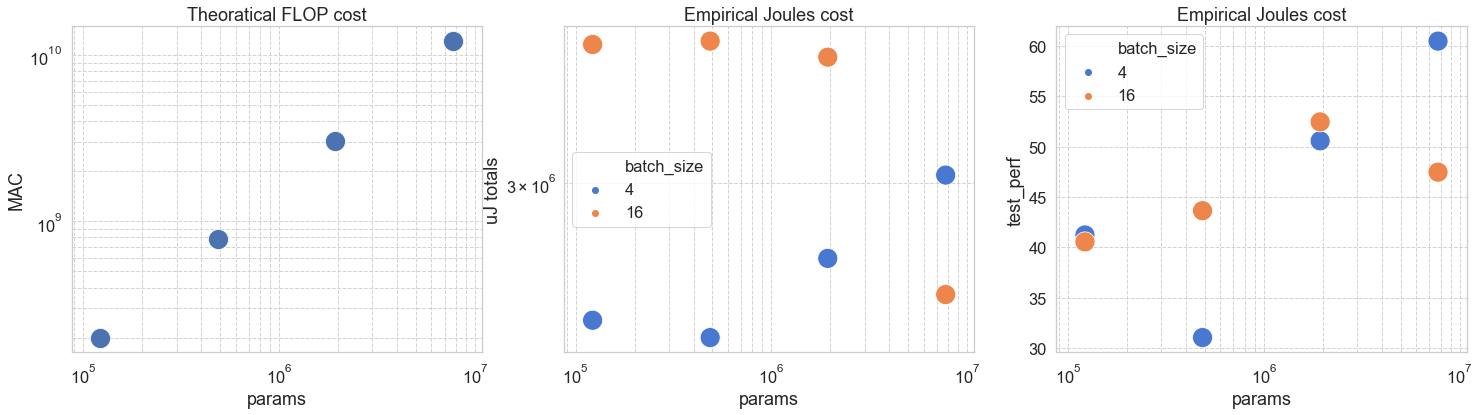

In [22]:
plot_df = total_joules.copy()
plot_df = convert_str_to_param_value(plot_df, 'params')
plot_df = convert_str_to_param_value(plot_df, 'MAC')

sns.set(font_scale = 1.5)
palette = sns.color_palette("muted", 2)
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1,3,figsize=(25,6),sharex=True,sharey=False)

    # FLOPs
    ax = axes[0]
    g = sns.scatterplot(x='params',y='MAC', s=400, data=plot_df, palette=palette,ax=ax)
    g.set(xscale="log",yscale="log")
    g.grid(True,which="both",ls="--",c='lightgray')
    ax.set_title('Theoratical FLOP cost')

    # Energy
    ax = axes[1]
    g = sns.scatterplot(x='params',y='uJ totals', hue='batch_size', s=400, data=plot_df, palette=palette,ax=ax)
    g.set(xscale="log",yscale="log")
    g.grid(True,which="both",ls="--",c='lightgray')
    ax.set_title('Empirical Joules cost')

    # Acc
    ax = axes[2]
    g = sns.scatterplot(x='params',y='test_perf', hue='batch_size', s=400, data=plot_df, palette=palette,ax=ax)
    g.set(xscale="log")
    g.grid(True,which="both",ls="--",c='lightgray')
    ax.set_title('Empirical Joules cost')

